Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Firstname Lastname | 01234567 | 25.05.2023, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 – Language Modeling with LSTM (Assignment)</h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 16-05-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.</p></p>

In [1]:
import u5_utils as u5

import numpy as np
import torch
import os
import time
import math
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

# Check minimum versions.
u5.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.23.5 (✓)
Installed pandas version: 1.4.4 (✓)
Installed PyTorch version: 2.0.1 (✓)
2.0.1
True


<h2>Language Model Training and Evaluation</h2>

<h3 style="color:rgb(0,120,170)">Data & Dictionary Preperation</h3>

<div class="alert alert-warning">
    <b>Exercise 1. [20 Points]</b>
        <ul>
            <li>Setup the data set using the same parameter settings as in the main exercise notebook but with the changes mentioned below.</li>
            <li>Change the batch size in the initial parameters to $64$ and observe its effect on the created batches. Explain how the corpora are transformed into batches.</li>
            <li>Use a seed of $23$.</li>
            <li>For a specific sequence in <code>val_data_splits</code> (e.g., index $15$), print the corresponding words of its first 25 wordIDs.</li>
        </ul>
</div>

In [13]:
data_path = os.path.join("resources", "penn")
save_path = "model.pt" # path to save the final model

# Training & evaluation parameters
train_batch_size = 64 # batch size for training
eval_batch_size = 64 # batch size for validation/test
max_seq_len = 40 # sequence length

# Random seed to facilitate reproducibility
torch.manual_seed(23)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

train_corpus = u5.Corpus(os.path.join(data_path, "train.txt"))
valid_corpus = u5.Corpus(os.path.join(data_path, "valid.txt"))
test_corpus = u5.Corpus(os.path.join(data_path, "test.txt"))

dictionary = u5.Dictionary()
train_corpus.fill_dictionary(dictionary)
ntokens = len(dictionary)
print(f"Number of tokens in dictionary {ntokens}")

# Some samples in the dictionary ...
print(f"wordID of a word in the dictionary: {dictionary.word2idx['book']}")
print(f"A word in the dictionary based on its wordID: '{dictionary.idx2word[854]}'")

train_data = train_corpus.words_to_ids(dictionary)
print(f"Train data: number of tokens {len(train_data)}")

valid_data = valid_corpus.words_to_ids(dictionary)
print(f"Validation data: number of tokens {len(valid_data)}")

test_data = test_corpus.words_to_ids(dictionary)
print(f"Test data: number of tokens {len(test_data)}")

print()
train_data_splits = u5.batchify(train_data, train_batch_size, device)
print(f"Train data split shape: {train_data_splits.shape}")

val_data_splits = u5.batchify(valid_data, eval_batch_size, device)
print(f"Validation data split shape: {val_data_splits.shape}")

test_data_splits = u5.batchify(test_data, eval_batch_size, device)
print(f"Test data batchified shape: {test_data_splits.shape}")

word_ids = val_data_splits[15, :25]
words = list()
for i_d in word_ids:
    words.append(dictionary.idx2word[i_d])
print(words)

Device: cuda
Number of tokens in dictionary 10001
wordID of a word in the dictionary: 1203
A word in the dictionary based on its wordID: 'says'
Train data: number of tokens 929589
Validation data: number of tokens 73760
Test data: number of tokens 82430

Train data split shape: torch.Size([14524, 64])
Validation data split shape: torch.Size([1152, 64])
Test data batchified shape: torch.Size([1287, 64])
['<unk>', 'video', 'of', 'in', 'and', 'as', 'accounts', 'crude', 'marine', 'it', 'vested', 'on', '<eos>', "'re", 'said', 'of', 'is', 'the', 'looked', 'sales', '<unk>', 'a', 'as', '<eos>', '<eos>']


Train data split [29049, 32] 

Validation data split [2305, 32] 

Test data batchified [2575, 32] 

train, validation, and test data shapes have changed, the first and second dimentions doubled 

tensor([  27, 2458,   43,  109,   49,   35, 1961, 1416, 5711,   79, 5501,  153,
          25,  132,   99,   43,   41,   33, 5827,  502,   27,   36,   35,   25,
          25], device='cuda:0')

<div class="alert alert-warning">
    <b>Exercise 2. [20 Points]</b>
        <ul>
            <li>Copy the implementation of <code>LM_LSTMModel</code> from the main exercise notebook but make the following changes:</li>
            <ul>
                <li>Add an integer parameter to <code>LM_LSTMModel</code>'s initialization, called <code>num_layers</code> which indicates the number of (vertically) stacked LSTM blocks. Hint: PyTorch's LSTM implementation directly supports this, so you simply have to set it when creating the LSTM instance (see parameter <code>num_layers</code> in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">documentation</a>).</li>
                <li>Add a new bool parameter to <code>LM_LSTMModel</code>'s initialization, called <code>tie_weights</code>. Extend the implementation of <code>LM_LSTMModel</code> such that if <code>tie_weights</code> is set to <code>True</code>, the model ties/shares the parameters of <code>encoder</code> with the ones of <code>decoder</code>. Consider that <code>encoder</code> and <code>decoder</code> still remain separate components but their parameters are now the same (shared). This process is called <i>weight tying</i>. Feel free to search the internet for relevant resources and implementation hints.</li>
            </ul>
            <li>Create four models:</li>
            <ul>
                <li>1 layer and without weight tying</li>
                <li>1 layer and with weight tying</li>
                <li>2 layers and without weight tying</li>
                <li>2 layers and with weight tying</li>
            </ul>
            <li>Compare the number of parameters of the models and report your observations.</li>
        </ul>
</div>

In [23]:
class LM_LSTMModel(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights: bool):
        super().__init__()
        self.tie_weights = tie_weights
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) # matrix E in the figure
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers = num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) # matrix U in the figure
        if tie_weights: self.decoder.weight = self.encoder.weight
    
    def forward(self, input, hidden=None, return_logs=True):
        #ipdb.set_trace()
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        
        return y_hat, last_hidden
    
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer

#     1 layer and without weight tying
#     1 layer and with weight tying
#     2 layers and without weight tying
#     2 layers and with weight tying

model1 = LM_LSTMModel(ntokens, emsize, nhid, 1, False)
model1.to(device)

print(f"Model-1: {model1}")
print(f"Model-1 total trainable parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad)}")

model2 = LM_LSTMModel(ntokens, emsize, nhid, 1, True)
model2.to(device)

print(f"Model-2: {model2}")
print(f"Model-2 total trainable parameters: {sum(p.numel() for p in model2.parameters() if p.requires_grad)}")

model3 = LM_LSTMModel(ntokens, emsize, nhid, 2, False)
model3.to(device)

print(f"Model-3: {model3}")
print(f"Model-3 total trainable parameters: {sum(p.numel() for p in model3.parameters() if p.requires_grad)}")

model4 = LM_LSTMModel(ntokens, emsize, nhid, 2, True)
model4.to(device)

print(f"Model-4: {model4}")
print(f"Model-4 total trainable parameters: {sum(p.numel() for p in model4.parameters() if p.requires_grad)}")

models = [model1, model2, model3, model4]

Model-1: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model-1 total trainable parameters: 4332001
Model-2: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model-2 total trainable parameters: 2331801
Model-3: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model-3 total trainable parameters: 4653601
Model-4: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model-4 total trainable parameters: 2653401


It's clear that the number of trainable parameters reduces due to tying weights which decreses processing time and tying weights can help with overfitting as well as help increase accuracy due to simmilarity of the weights and words 

<h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>


<div class="alert alert-warning">
    <b>Exercise 3. [30 Points]</b>
    <ul>
        <li>Using the same setup as in the main lecture/exercise notebook, train all four models for $5$ epochs.</li>
        <li>Using <code>ipdb</code>, look inside the <code>forward</code> function of <code>LM_LSTMModel</code> during training. Check the forward process from input to output particularly by looking at the shapes of tensors. Report the shape of all tensors used in <code>forward</code>. Try to translate the numbers into batches $B$ and sequence length $L$. For instance, if we know that the batch size is $B=32$, a tensor of shape $(32, 128, 3)$ can be interpreted as a batch of $32$ sequences with $3$ channels of size $L=128$. Thus, this tensor can be translated into $(32, 128, 3) \rightarrow (B, L, 3)$. Look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">official documentation</a> to understand the order of the dimensions.</li>
        <li>Evaluate the models. Compare the performances of all four models on the train, validation and test set (for the test set, use the best model according to the respective validation set performance), and report your observations. To do so, create a plot showing the following curves:</li>
        <ul>
            <li>Loss on each current training batch before every model update step as function of epochs</li>
            <li>Loss on the validation set at every epoch</li>
        </ul>
        <li>Comment on the results!</li>
    </ul>
</div>

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 84.37 | loss  4.84 | perplexity   126.65
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 71.13 | loss  4.64 | perplexity   103.11
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 73.29 | loss  4.68 | perplexity   107.51
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 70.97 | loss  4.69 | perplexity   108.42
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 70.90 | loss  4.65 | perplexity   104.07
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 70.95 | loss  4.54 | perplexity    93.70
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 70.85 | loss  4.65 | perplexity   105.07
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 70.76 | loss  4.85 | perplexity   127.70
----------------------------------------------------------------------------------------------------
| end of epoch   0 | time: 15.31s| valid loss  5.49 | valid perplexity   243.27
-------------------------------------------

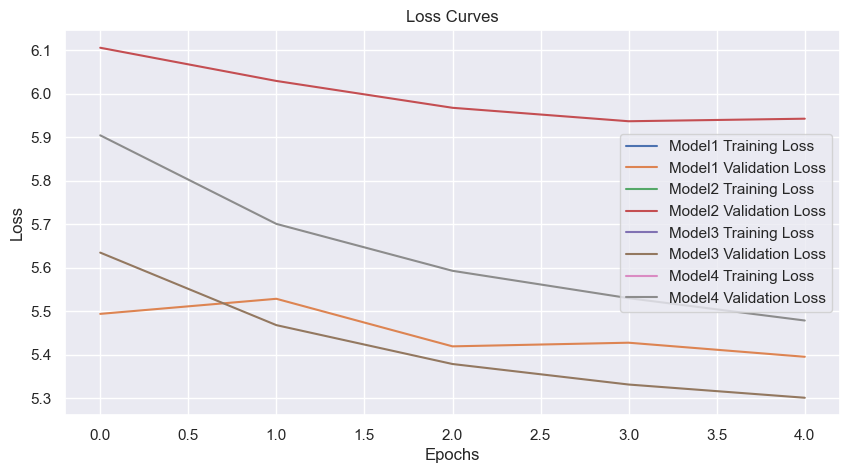

In [26]:
CUT_AFTER_BATCHES = 200  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

def plot_losses(model_losses, model_names):
    plt.figure(figsize=(10,5))

    for model_loss, model_name in zip(model_losses, model_names):
        plt.plot(model_loss[0], label=f'{model_name} Training Loss')
        plt.plot(model_loss[1], label=f'{model_name} Validation Loss')

    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        #ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u5.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break
model_losses = []
model_names = ["Model1", "Model2", "Model3", "Model4"]            
for model in models:
    epochs = 5  # total number of training epochs
    print_interval = 25  # print report statistics every x batches
    lr = 20  # initial learning rate
    clipping = 0.25  # gradient clipping
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_losses = []
    val_losses = []
    best_val_loss = None

    # Loop over epochs.

    for epoch in range(epochs):
        epoch_start_time = time.time()
        train_loss = train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
        val_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("-" * 100)
        print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
              f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
        print("-" * 100)

        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(save_path, "wb") as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
            for g in optimizer.param_groups:
                g["lr"] = lr
    model_losses.append((train_losses, val_losses))
plot_losses(model_losses, model_names)

your answer goes here

<h2>Language Generation</h2>

<div class="alert alert-warning">
    <b>Exercise 4. [30 Points]</b>
    <p>
    Copy the language generation code from the main exercise notebook and perform the following tasks:
    </p>
        <ul>
            <li>Compare all four previous models by generating $12$ words that append the starting word <tt>"despite"</tt>.</li>
            <li>For each model, retrieve the top $10$ wordIDs with the highest probabilities from the generated probability distribution (<code>prob_dist</code>) following the starting word <tt>"despite"</tt>. Fetch the corresponding words of these wordIDs. Do you observe any specific linguistic characteristic common between these words?</li>
            <li>The implementation in the main exercise notebook is based on sampling. Implement a second deterministic variant based on the <i>top-1</i> approach. In this particular variant, the generated word is the word with the highest probability in the predicted probability distribution. Repeat the same procedure as before (i.e., generate $12$ words that append the starting word <tt>"despite"</tt>).</li>
        </ul>
</div>

In [33]:
GENERATION_LENGTH = 12
START_WORD = "despite"

for model_idx, model in enumerate(models):
    print(f"Model {model_idx + 1}")
    
    start_hidden = None
    wordid_input = dictionary.word2idx[START_WORD.lower()]
    generated_text = START_WORD
    
    with torch.no_grad():
        for _ in range(GENERATION_LENGTH):
            data = torch.tensor([wordid_input]).unsqueeze(1).to(device)
            
            y_hat_probs, last_hidden = model(data, start_hidden)
            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            wordid_input = prob_dist.sample().item()
            generated_text += " " + dictionary.idx2word[wordid_input]
            start_hidden = last_hidden

    print(f"Generated text (probabilistic): {generated_text}")

    top10_wordids = y_hat_probs.squeeze().topk(10).indices.tolist()
    top10_words = [dictionary.idx2word[wordid] for wordid in top10_wordids]
    print(f"top 10 wordIDs with the highest probabilities: {top10_words}")
    
    start_hidden = None
    wordid_input = dictionary.word2idx[START_WORD.lower()]
    generated_text = START_WORD

    with torch.no_grad():
        for _ in range(GENERATION_LENGTH):
            data = torch.tensor([wordid_input]).unsqueeze(1).to(device)
            
            y_hat_probs, last_hidden = model(data, start_hidden)
            wordid_input = y_hat_probs.argmax().item()
            generated_text += " " + dictionary.idx2word[wordid_input]
            start_hidden = last_hidden

    print(f"Generated text (deterministic): {generated_text}\n")


Model 1
Generated text (probabilistic): despite episode lowest synthetic bargaining unusual centerpiece bullet contains dealers mining instituted russians
Top 10 probable words: ['a', 'the', 'effect', '<unk>', 'by', 'new', 'its', 'ual', 'stock', 'control']
Generated text (deterministic): despite the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Model 2
Generated text (probabilistic): despite maine address unauthorized liberation grocery commute galvanized crazy cell forgotten known albert
Top 10 probable words: ['as', 'to', 'in', 'and', 'for', 'they', 'the', '<eos>', 'will', 'through']
Generated text (deterministic): despite the <unk> of the <unk> of the <unk> of the <unk> of

Model 3
Generated text (probabilistic): despite unanimously rout preventing phillips potentially chart promising determining booked suggesting delivery enhanced
Top 10 probable words: ['<eos>', 'in', 'and', 'to', 'of', 'for', 'with', 'that', 'on', 'as']
Generated text (deterministic): despite

your answer goes here